# Plotting spacecraft trajectories over images

In [1]:
%load_ext autoreload

%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime as datetime
from datetime import timedelta
import seaborn as sns
import pandas as pd

import copy as cp

import py3dcore_h4c as py3dcore_h4c

import fluxplot as fp

import warnings
warnings.filterwarnings('ignore')

from sunpy.time import parse_time
import heliopy.spice as spice
import heliopy.data.spice as spicedata

import astropy
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord

from sunpy.net.helioviewer import HelioviewerClient
from sunpy.map import Map
from sunpy.coordinates import frames


print(sns.__version__)

0.12.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.image import imread
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D

import datetime
from datetime import timedelta
import seaborn as sns
import pandas as pd
import os

import sunpy
from sunpy.time import parse_time
import sunpy.data.sample
import sunpy.map
from sunpy.net.helioviewer import HelioviewerClient
from sunpy.map import Map
from sunpy.coordinates import frames
import drms
import glymur
import zeep

import astropy
import astropy.units as u

import astropy
import astropy.constants as const
from astropy.coordinates import SkyCoord


import heliopy
import heliopy.spice as spice
import heliopy.data.spice as spicedata

import glob

import py3dcore_h4c

#import astroquery


import warnings
warnings.filterwarnings('ignore')

## get PSP positions

In [2]:
def cart2sphere(x,y,z):
    r = np.sqrt(x**2+ y**2 + z**2)           
    theta = np.arctan(z/np.sqrt(x**2+ y**2))
    phi = np.arctan2(y,x)                    
    return (r, theta, phi)


frame='HEEQ'
starttime = datetime.datetime(2018, 8,13)
endtime = datetime.datetime(2025, 8, 31)
pspt_time = []
res_in_days=1/48.
while starttime < endtime:
    pspt_time.append(starttime)
    starttime += timedelta(days=res_in_days)
pspt_time_num=parse_time(pspt_time).plot_date

spice.furnish(spicedata.get_kernel('psp_pred'))
pspt=spice.Trajectory('SPP')
pspt.generate_positions(pspt_time,'Sun',frame)
psp_speed=pspt.speed.value
pspt.change_units(astropy.units.AU)  
[psp_r, psp_lat, psp_lon]=cart2sphere(pspt.x,pspt.y,pspt.z)
print('PSP pos')
print()

lon=np.degrees(psp_lon.value)
print(lon)
lat=np.degrees(psp_lat.value)
print(lat)
r=psp_r.value
print(r)
ptime=pspt_time

psp_x=pspt.x.value
psp_y=pspt.y.value
psp_z=pspt.z.value

PSP pos

[-0.26736573 -0.2756879  -0.28400928 ...  7.04771653  7.05028505
  7.05288513]
[6.47275143 6.47224984 6.47174814 ... 3.85815706 3.85817297 3.8581883 ]
[1.01317831 1.01317197 1.01316555 ... 0.51436421 0.5140078  0.51365099]


## single image test

In [6]:

hv = HelioviewerClient()
#look at data sources
#hv.get_data_sources()

#https://docs.sunpy.org/en/latest/guide/acquiring_data/helioviewer.html


############################### LASCO

# copy this in the console to get a list of viable data sources
#hv.get_data_sources())

t1='2012/07/23 04:00:00'

#file = hv.download_jp2('2020/08/01', observatory="SDO", instrument="AIA",    measurement="304") 
#file = hv.download_jp2('2017/05/23', observatory="STEREO_A", instrument="SECCHI", detector='COR2'  ,  measurement="white-light") 
#file = hv.download_jp2('2012/07/23 04:00:00', observatory="SOHO", instrument="LASCO", detector='C3'  ,  measurement="white-light") 
file = hv.download_jp2(t1, observatory="SOHO", instrument="LASCO", detector='C3',  measurement="white-light") 


las = Map(file)  

lasrot = las.rotate(angle=5 * u.deg)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [9]:
#get index of flyby
fs_start_ind=np.where(mdates.date2num(ptime) > mdates.date2num(datetime.datetime(2024, 12,24)))[0][0]
fs_end_ind=np.where(mdates.date2num(ptime) > mdates.date2num(datetime.datetime(2024, 12,25)))[0][0]

## initiate 3DCORE

In [12]:
t_launch = datetime.datetime(2012, 7,23, 0)

iparams_arr = np.array([[
    0,      # time offset
    90,    # l_1 (logitude) HEEQ
    20,    # l_2 (latitude)
    60,      # o (inclination, orientation)
    0.24,   # d_1au (frontal width at 1AU)
    5,   # delta (cross-section aspect ratio)
    5,      # r_0 (initialization distance in solar radii)
    600,    # v_0 (initial velocty in)
    -4,      # tau (magnetic field twist)
    1.0,      # b_s (magnetic field scaling parameter)
    20,     # b_1au (magnetic field strength at 1au)
    1.5,    # Gamma (solar wind drag coefficient)
    400,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

overwrite = {
    "cme_longitude": {
            "maximum": 91,
            "minimum": 89
        },
    "cme_latitude": {
            "maximum": 21,
            "minimum": 19
        },
    "cme_inclination" :{
            "maximum": 61,
            "minimum": 59
        },
    "cme_diameter_1au" :{
            "maximum": 0.25,
            "minimum": 0.23
        },
    "cme_aspect_ratio": {
            "maximum": 5.1,
            "minimum": 4.9
        },
    "cme_launch_radius": {
            "maximum": 5.1,
            "minimum": 4.9
        },
    "cme_launch_velocity": {
            "maximum": 601,
            "minimum": 599
        },
    "t_factor": {
            "maximum": -3.9,
            "minimum": -4.1
        },
    "magnetic_field_strength_1au": {
            "maximum": 21,
            "minimum": 19
        },
    "background_drag": {
            "maximum": 1.6,
            "minimum": 1.4
        },
    "background_velocity": {
            "maximum": 405,
            "minimum": 395
        },
}

model_obj = py3dcore_h4c.ToroidalModel(t_launch, 1, iparams=overwrite)


In [20]:
#measurement times 
tm0 =  t_launch + datetime.timedelta(days=0.1)
tm1 =  t_launch + datetime.timedelta(days=0.2)
tm2 =  t_launch + datetime.timedelta(days=0.3)
tm3 =  t_launch + datetime.timedelta(days=0.4)
tm4 =  t_launch + datetime.timedelta(days=0.5)




def plot_3dcore(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .05)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)

    #ax.scatter(0, 0, 0, color="y", s=500)

    model_obj.propagator(t_snap)
    wf_model = model_obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs)
    
    
#define sun here so it does not need to be recalculated every time
scale=695510/149597870.700*1 #Rs in km, AU in km
# sphere with radius Rs in AU
u1, v1 = np.mgrid[0:2*np.pi:40j, 0:np.pi:30j]
xs = np.cos(u1)*np.sin(v1)*scale
ys = np.sin(u1)*np.sin(v1)*scale
zs = np.cos(v1)*scale



def plot_configure(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    #adjust scaling as matplotlib lacks automatic aspect ratio setting
    ax.set_zlim([-view_radius*0.75, view_radius*0.75])    

    
    #solar equatorial plane
    #for p in np.arange(-2,2,0.2):
    #    ax.plot([-2,2],[p,p],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    #    ax.plot([p,p],[-2,2],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    
    #draw sun        
    ls = LightSource(azdeg=140, altdeg=40)  
    ax.plot_surface(xs, ys, zs, rstride=1, cstride=1, color='yellow',lightsource=ls, linewidth=0, antialiased=False,zorder=5)
    
    
    ax.set_axis_off()    

## plot

coordinates of observer  <Helioprojective Frame (obstime=2012-07-23T03:54:07.231, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2012-07-23T03:54:07.231, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., 5.10195203, 1.51979516e+11)>)>
WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 0.0  0.0  
CRPIX : 560.34424384146  577.00403300789  
PC1_1 PC1_2  : 0.99619469809175  0.087155742747658  
PC2_1 PC2_2  : -0.087155742747658  0.99619469809175  
CDELT : 0.015555555555556  0.015555555555556  
NAXIS : 1110  1110
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


ValueError: thin_torus_qs: Output operand 0 has a mismatch in its core dimension 0, with gufunc signature (i), (j), (k), (l) -> (i) (size 4 is different from 3)

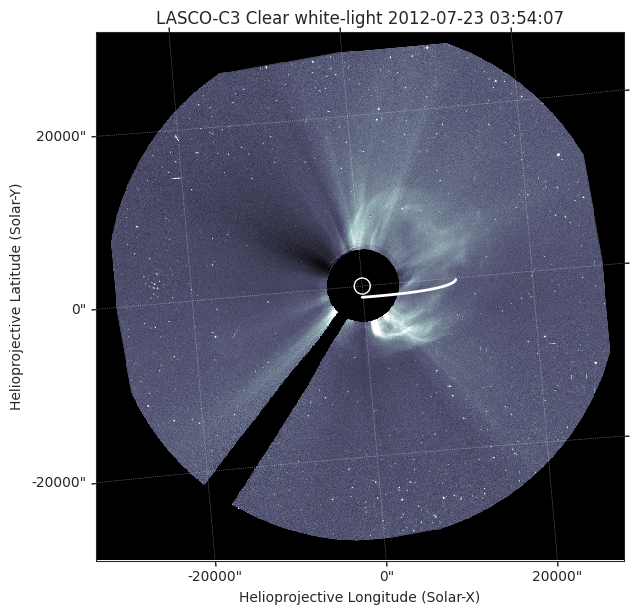

In [33]:
sns.set_style('white')
fig = plt.figure(1,figsize=(15, 8),dpi=100)


################################### plot 1

ax1 = plt.subplot(121, projection=lasrot)

print('coordinates of observer ',lasrot.coordinate_frame)
print(lasrot.wcs)

#plot image
lasrot.plot()
lasrot.draw_limb()
#plt.colorbar()

#psp position as SkyCoord object
px=psp_x[fs_start_ind:fs_end_ind]
py=psp_y[fs_start_ind:fs_end_ind]
pz=psp_z[fs_start_ind:fs_end_ind]

#scale AU to Rs
au2rs=(const.au/const.R_sun).value


pc = SkyCoord(px*u.AU, py*u.AU, pz*u.AU, frame='heliographic_stonyhurst',representation_type='cartesian')
ax1.plot_coord(pc, linestyle='solid', linewidth=2, color='white')


import fluxplot as fp

############## plot 3dcore in ax1 ** to do
model_obj.generator()
model_obj.propagator(tm0)
wf_model = fp.visualize_wireframe(model_obj,index=0)

mc= SkyCoord(wf_model.T[0,:,:]*u.AU, wf_model.T[1,:,:]*u.AU, wf_model.T[2,:,:]*u.AU, frame='heliographic_stonyhurst',representation_type='cartesian')

ax1.plot_coord(mc,color='white',linewidth=1,alpha=0.7)

################################## plot 2

ax2 = plt.subplot(122)

#ax2.plot(ptime[fs_start_ind:fs_end_ind],psp_r[fs_start_ind:fs_end_ind])
ax2.plot(px*au2rs,py*au2rs,'k')
ax2.set_xlabel('x [R_sun, HEEQ]')
ax2.set_ylabel('y [R_sun, HEEQ]')
ax2.grid(True)

#https://docs.sunpy.org/en/stable/code_ref/coordinates/index.html
#c = SkyCoord(x=-72241.0*u.km, y=361206.1*u.km, z=589951.4*u.km, frame=frames.Heliocentric)


j=5
ax1.plot_coord(pc[j], 'o', markersize=10, mec='black', mfc='white')
ax2.plot(px[j]*au2rs,py[j]*au2rs,'o', markersize=10, mec='black', mfc='white')
ax2.text(px[j]*au2rs,py[j]*au2rs,'1',ha='left',va='bottom')

j=30
ax1.plot_coord(pc[j], 'o', markersize=10, mec='black', mfc='white')
ax2.plot(px[j]*au2rs,py[j]*au2rs,'o', markersize=10, mec='black', mfc='white')
ax2.text(px[j]*au2rs,py[j]*au2rs,'2',ha='left',va='bottom')





plt.savefig('results/imaging/lasco_test_' + str(j+1) + '.png')


print('timerange',ptime[fs_start_ind],ptime[fs_end_ind])